In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print("All packages imported successfully!")

All packages imported successfully!


In [2]:
# Check GPU device
device = torch.device("cpu")

In [3]:
# Dataset 
xy = pd.read_csv("_data/bottle.csv")

xy.head()

C:\Users\paulo.akira.f.enabe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (47,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# retrieve salinity and temperature columns
x_raw = xy.iloc[:,5] # salinity 
y_raw = xy.iloc[:,6] #temperature

In [5]:
# verify if there is any data missing
print(f'Salinity missing data summation: {x_raw.isna().sum()}')
print(f'Temperature missing data summation: {y_raw.isna().sum()}')

Salinity missing data summation: 10963
Temperature missing data summation: 47354


In [6]:
# fill missing data with ffill
x_raw = x_raw.fillna(axis=0,method='ffill')
y_raw = y_raw.fillna(axis=0,method='ffill')

In [7]:
# verify if data was filled
print(f'Salinity missing data summation: {x_raw.isna().sum()}')
print(f'Temperature missing data summation: {y_raw.isna().sum()}')

Salinity missing data summation: 0
Temperature missing data summation: 0


In [8]:
# reshape data
x = np.array(x_raw).reshape(-1,1) # Temperature
y = np.array(y_raw).reshape(-1,1) # Salinity

In [9]:
# Split into train+validation and test sets
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, 
                                        random_state=69)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.1,
                                random_state=21)

In [10]:
# Normalizing the input (x in [0,1])
scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_val = scale.fit_transform(x_val)
x_test = scale.fit_transform(x_test)

x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

In [11]:
# define hyperparameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001

input_size = 1 # Number of features
output_size = 1

In [12]:
# Create dataloaders to Pytorch models
class Salinity(Dataset):
    ''' Receive a dataset and preprocess to transform into data loaders
    
        Input:
            x_data (float numpy array): input values
            y_data (float numpy array): expected output value
    '''
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data
        self.n_samples = len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

train_dataset = Salinity(torch.from_numpy(x_train.astype(np.float32)), torch.from_numpy(y_train.astype(np.float32)))
val_dataset = Salinity(torch.from_numpy(x_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.float32)))
test_dataset = Salinity(torch.from_numpy(x_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32)))

# Dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [13]:
# neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [14]:
# model implementation
model = nn.Linear(input_size, output_size)
model.to(device)

Linear(in_features=1, out_features=1, bias=True)

In [15]:
# Loss function and optimizer

# Mean Square Error 
criterion = nn.MSELoss() 

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) 

print(model)

Linear(in_features=1, out_features=1, bias=True)


In [16]:
# iterations
for e in tqdm(range(1, num_epochs+1)):
    for X_train_batch, y_train_batch in train_loader:
        # alloacate to GPU or CPU
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # clean the gradients
        optimizer.zero_grad() 
        
        # forward pass
        y_train_pred = model(X_train_batch)        
        train_loss = criterion(y_train_batch, y_train_pred)
        
        # backward pass
        train_loss.backward()
        
        # update weights
        optimizer.step()

        # clean the gradients
        optimizer.zero_grad()

    print(f'Epoch: {e}, Loss: {train_loss:.4f}')


Epoch: 1, Loss: 3.3986
Epoch: 2, Loss: 2.2010
Epoch: 3, Loss: 1.4362
Epoch: 4, Loss: 0.9458
Epoch: 5, Loss: 0.6296
Epoch: 6, Loss: 0.4247
Epoch: 7, Loss: 0.2908
Epoch: 8, Loss: 0.2027
Epoch: 9, Loss: 0.1442
Epoch: 10, Loss: 0.1049
Epoch: 11, Loss: 0.0781
Epoch: 12, Loss: 0.0598
Epoch: 13, Loss: 0.0469
Epoch: 14, Loss: 0.0379
Epoch: 15, Loss: 0.0314
Epoch: 16, Loss: 0.0267
Epoch: 17, Loss: 0.0232
Epoch: 18, Loss: 0.0207
Epoch: 19, Loss: 0.0187
Epoch: 20, Loss: 0.0173



In [17]:
# inference 

# transform into tensor
x = torch.from_numpy(x_test.astype(np.float32))

# prediction
predicted = model(x).detach().numpy()

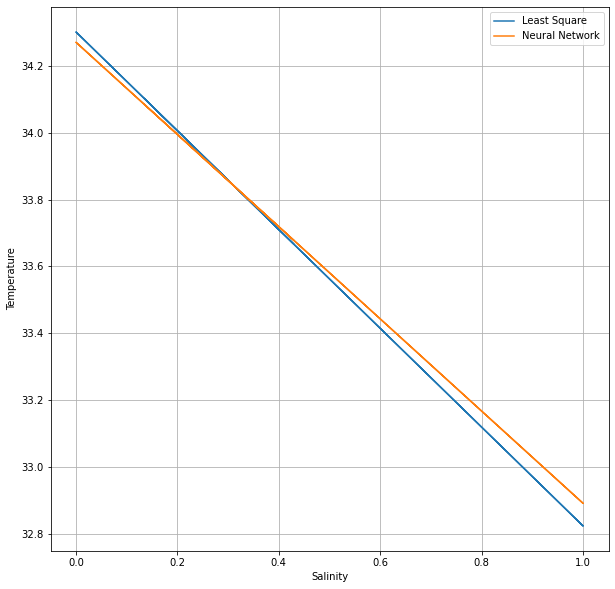

In [18]:
from sklearn import linear_model

# sklearn's Least Square Method
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# Plot outputs
plt.figure(figsize=(10, 10))
plt.plot(x_test, y_pred , label='Least Square') # Least Square Method approach
plt.plot(x_test, predicted, label='Neural Network') # Neural Network approach
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.show()